### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2017/2018)

* The lab exercises should be made in groups of two or three people.
* The deadline is Friday, 01.06.
* Assignment should be submitted through BlackBoard! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [182]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


/Volumes/Macintosh_HD/Users/Aron/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes', 'sample', 'gamma', 'pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [183]:
def binarize(X):
    return np.array(X > 128, dtype=np.float)

In [184]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

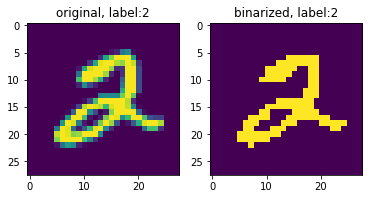

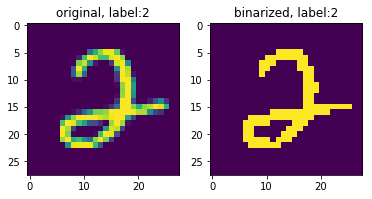

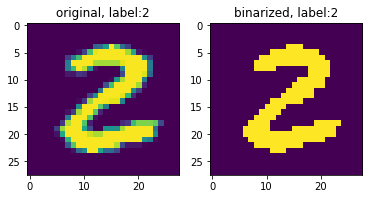

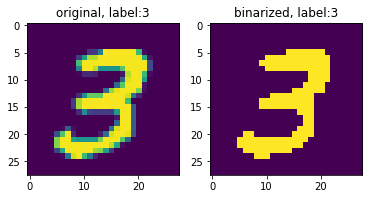

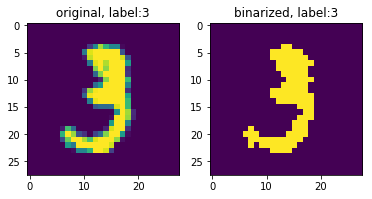

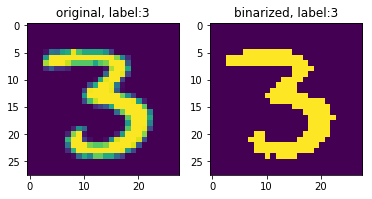

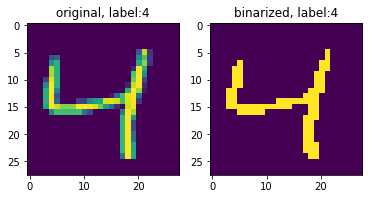

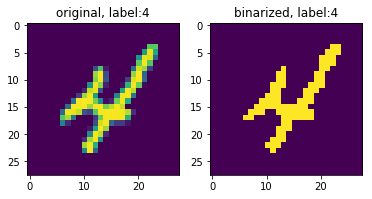

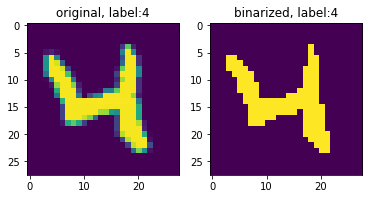

In [185]:
twos = np.argwhere(train_labels == 2)
threes = np.argwhere(train_labels == 3)
fours = np.argwhere(train_labels == 4)
sample = np.concatenate((twos[:3], threes[:3], fours[:3]))

for image_idx in sample:
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(train_data[image_idx].reshape(28, -1))
    axes[0].set_title("original, label:"+ str(train_labels[image_idx][0]))
    axes[1].imshow(bin_train_data[image_idx].reshape(28, -1))
    axes[1].set_title("binarized, label:"+ str(train_labels[image_idx][0]))

### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [186]:
from scipy.special import logsumexp
def E_step(X, mu, pi):

    stabilizer = 1e-6
    
    #Bishop 9.56
    enumerator = X @ np.log(mu+stabilizer).T + (1.0-X) @ np.log(1.0-mu.T+stabilizer) + np.log(pi)
#     enumerator = np.dot(X, np.log(mu+stabilizer).T) + np.dot((1.0-X), np.log(1.0-mu.T+stabilizer)) + np.log(pi)
    denominator = logsumexp(enumerator, axis=1, keepdims=True)
    gamma = np.exp(enumerator - denominator)
    
    return gamma

In [187]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [188]:
def M_step(X, gamma):
    #keep dims to be able to divide the whole matrix at once for Pi
    Nk_vec = gamma.sum(axis=0, keepdims=True) #gamma dims = (nxk), Nk dims= (1xk)
    
    # EDIT: N afleiden van data ipv in argument
    N, D = X.shape
    _, K = gamma.shape
    
    # Our interpretation of 9.58:
#     mu = np.zeros((K, D))
#     for k in range(K):
#         mu[k, :] = gamma[:, k] @ X
#     mu = mu / Nk_vec.T
    
    # Working implementation of 9.58
    mu = gamma.T @ X
    mu = mu / Nk_vec.T
    
    pi = np.squeeze(Nk_vec/N)
        
    return mu, pi

In [189]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [190]:
def log_x_mu(X, MU):
    '''Log and matrix version of bishop 9.48'''
    
    # X = [N, D]
    # MU = [K, D]
    # return [N, K]
    
    stabilizer = 1e-3
    return X @ np.log(MU.T + stabilizer) + (1.0-X) @ np.log(1 - MU.T + stabilizer)


def log_likelihood(gamma, pi, X, mu):
    
    # [1, K]
    log_pi = np.log(pi + 1e-10).reshape(1, -1)
    
#     print("log pi", log_pi)
    
    # [N, K]
    weighted_log_probs = log_pi + log_x_mu(X, mu)
    
#     print("log x mu", log_x_mu(X, mu))
    
    # Element wise multiplication between gamma and weighted
    # log-probabilities and then summed over N and K
    result = np.sum(gamma * weighted_log_probs)
    
#     print("gamma * weighted", gamma * weighted_log_probs)
    
    return result

In [191]:
def EM(X, K, max_iter, mu=None, pi=None):
    
    # 'Calculate' N and D
    N,D = X.shape
    
    if not np.any(mu) or not np.any(pi):
        # Init
        pi = np.ones(K)/K
        mu = np.random.rand(K,D)
    else:
        assert K == mu.shape[0]
        
    best_log_likelihood = -inf
    epsilon = 1e-6 # change in likelihood must be bigger than epsilon

    for i in range(max_iter):
        
        if i % 20 == 0:
            print('itaration: ', i, '/', max_iter)
        
        #perform E-step
        gamma = E_step(X,mu,pi)        
        
        #perform M-step
        mu,pi = M_step(X, gamma)
        
#         print("mu", mu)
#         print("pi", pi)
#         print("gamma", gamma)
#         print("log-like", log_likelihood(gamma, pi, X, mu))
                
#         print("M-step mu and pi", (mu, pi))
        
        log_like = log_likelihood(gamma, pi, X, mu)
        delta = log_like - best_log_likelihood
        
#         print('log-like: ', log_like)
#         print('best log like: ',best_log_likelihood)
        # Keep track of log likelihood
        log_like = log_likelihood(gamma, pi, X, mu)
        delta = log_like - best_log_likelihood    
        if delta > 0:
            best_log_likelihood = log_like
            
            # Stop on convergence
            if delta < epsilon:
                print("Converged")
                break
            
    
    return mu, gamma, best_log_likelihood, pi

In [192]:
mu, gamma, log_like, pi = EM(X_test, 5, 5)
log_like

itaration:  0 / 5


-405.02143325616692

### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

In [193]:
# Initialize seed so EM converges to the same thing everytime
# This is useful to be able to make a mapping between the cluster centers and the predicted label
# (once, and not everytime the EM algorithm is run again)
random.seed(2018)


twos = np.argwhere(train_labels == 2)
threes = np.argwhere(train_labels == 3)
fours = np.argwhere(train_labels == 4)
labels = [2,3,4]
samples_per_class = 1000
sample_indices = np.concatenate((twos[:samples_per_class], threes[:samples_per_class], fours[:samples_per_class]))
samples = np.squeeze(bin_train_data[sample_indices])
sample_labels = np.squeeze(train_labels[sample_indices])
samples.shape
# X_test.shape
mu, gamma, best_log_likelihood, pi = EM(samples, 3, 200)

itaration:  0 / 200
itaration:  20 / 200
itaration:  40 / 200
itaration:  60 / 200
itaration:  80 / 200
Converged


Mixing coefficients:  [ 0.337  0.306  0.356]
True mixing coefficients:  [ 0.333  0.333  0.333]


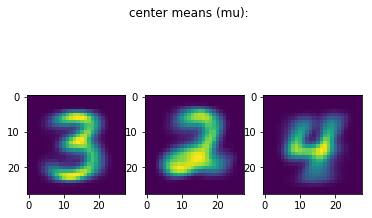

In [194]:
def reconstruction_visualization(mu, pi, samples_per_class, samples):
    plt.figure()
    K = pi.shape[0]
    
    for cluster_center in range(K):

        plt.subplot(1, K,cluster_center+1)
        plt.imshow(mu[cluster_center].reshape(28, -1))
    plt.suptitle("center means (mu):")

    print("Mixing coefficients: ", np.around(pi, decimals=3))
    true_mixing = np.ones(3)*samples_per_class/samples.shape[0]
    print("True mixing coefficients: ",np.around(true_mixing, decimals=3))

reconstruction_visualization(mu, pi, samples_per_class, samples)

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

#### Answer

The elements correspond to 3,2,4 from left to right (given that the random seed is set at 2018). The mixing coefficients and the true mixing coefficients are depicted above the plot. The mixing coefficients don't differ too much from the true ones, the EM algorithm thus did a fairly good job

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

In [195]:
random.seed(2018)
# K smaller than the true number of classes
mu, gamma, best_log_likelihood, pi = EM(samples, 2, 200)



itaration:  0 / 200
itaration:  20 / 200
itaration:  40 / 200
itaration:  60 / 200
itaration:  80 / 200
itaration:  100 / 200
itaration:  120 / 200
itaration:  140 / 200
itaration:  160 / 200
itaration:  180 / 200


Mixing coefficients:  [ 0.387  0.613]
True mixing coefficients:  [ 0.333  0.333  0.333]


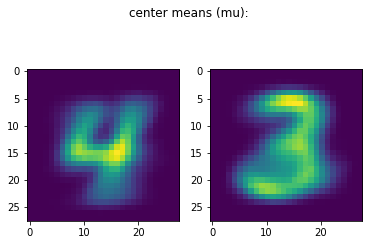

In [196]:
reconstruction_visualization(mu, pi, samples_per_class,samples)

In [197]:
random.seed(2018)
# K bigger than the true number of classes
mu, gamma, best_log_likelihood, pi = EM(samples, 5, 200)

itaration:  0 / 200
itaration:  20 / 200
itaration:  40 / 200
itaration:  60 / 200
itaration:  80 / 200
itaration:  100 / 200
itaration:  120 / 200
itaration:  140 / 200
itaration:  160 / 200
itaration:  180 / 200


Mixing coefficients:  [ 0.18   0.186  0.347  0.147  0.14 ]
True mixing coefficients:  [ 0.333  0.333  0.333]


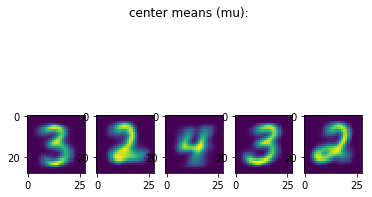

In [198]:
reconstruction_visualization(mu, pi, samples_per_class,samples)

## Answer

With a K bigger than the true number of classes some mu's/centers depict the same digit. These are potentially the centers of sub-clusters containing different styles of one digit.

With a K smaller than the true number of classes, the reconstructed digits are more blurred. This is because in this case perfect assignment is impossible and at least one of the means is the center of a cluster containing multiple digits. In the example above it looks lik the datapoints containing 2's have been divided accros the means for the other two clusters. From the learned mixing coefficients it is seems that most of the 2's have been assigned to the cluster with 3's.

NB: The answer above is based on results obained using the random seed 2018

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

In [199]:
random.seed(2018)
mu, gamma, best_log_likelihood, pi = EM(samples, 3, 200)

itaration:  0 / 200
itaration:  20 / 200
itaration:  40 / 200
itaration:  60 / 200
itaration:  80 / 200
Converged


Mixing coefficients:  [ 0.337  0.306  0.356]
True mixing coefficients:  [ 0.333  0.333  0.333]


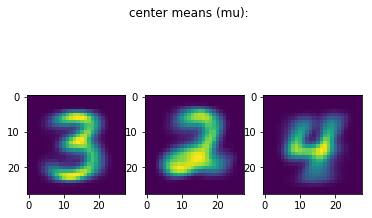

In [200]:
reconstruction_visualization(mu, pi, samples_per_class,samples)

In [203]:
def misslassification_experiment(plotting = False, all_samples = False):
    random.seed(2018)
    mapping = {0:3, 1:2, 2:4}
    misclassification_counter = 0
    predicted_labels = [0,0,0]
    N=10
    
    for i in range(len(samples)):
        image_index = np.random.choice(len(samples)) 

        assigned_k = np.argmax(gamma[image_index,:])
        predicted_label = mapping[assigned_k]
        true_label = sample_labels[image_index]
        np.delete(samples, image_index)
        if (predicted_label != true_label):
            # to distinguish which label has been mispredicted more often
            if predicted_label == 2:
                predicted_labels[0]+=1
            if predicted_label == 3:
                predicted_labels[1]+=1
            if predicted_label == 4:
                predicted_labels[2]+=1

            misclassification_counter +=1

            if plotting == True:
                plt.figure()
                plt.imshow(samples[image_index].reshape(28, -1))
                plt.title(str(misclassification_counter)+") True label: "+
                          str(true_label)+" predicted label: "+str(predicted_label))
                
                if misclassification_counter == N:
                    break
    
    return predicted_labels

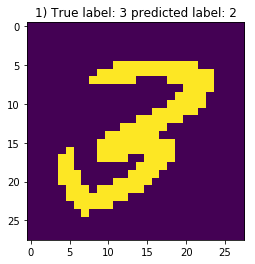

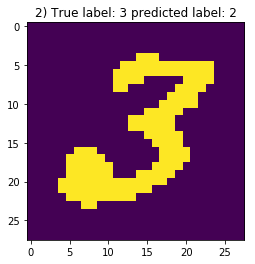

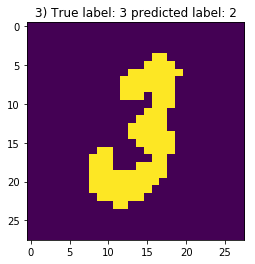

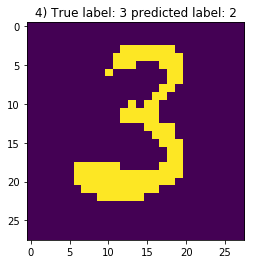

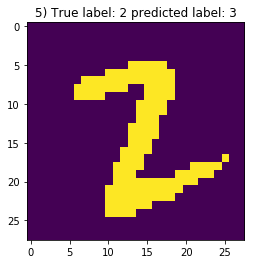

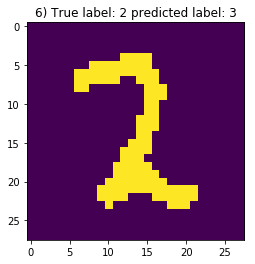

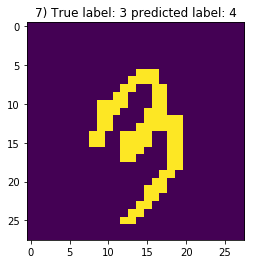

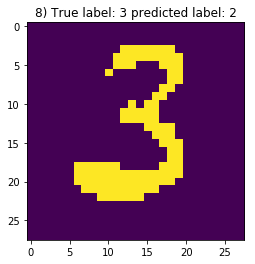

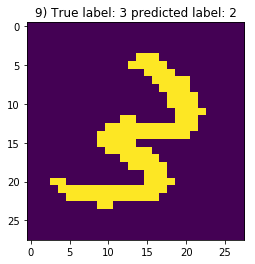

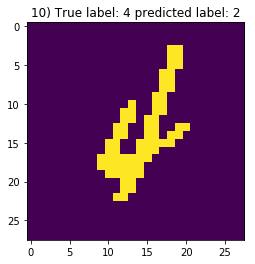

In [204]:
misslassification_experiment(True)
predicted_labels = misslassification_experiment(False, True)

In [205]:
print("The digit with true label 2 has been mispredicted",(predicted_labels[0]/sum(predicted_labels))*100,"% of the times in the sample above")
print("The digit with true label 3 has been mispredicted",(predicted_labels[1]/sum(predicted_labels))*100,"% of the times in the sample above")
print("The digit with true label 4 has been mispredicted",(predicted_labels[2]/sum(predicted_labels))*100,"% of the times in the sample above")

print("Total misclassification:", sum(predicted_labels), "/3000")

The digit with true label 2 has been mispredicted 35.9861591696 % of the times in the sample above
The digit with true label 3 has been mispredicted 38.4083044983 % of the times in the sample above
The digit with true label 4 has been mispredicted 25.6055363322 % of the times in the sample above
Total misclassification: 289 /3000


## Answer:
First of all, the above experiment indicates that the digits with true labels 2 or 3 were misclassified a lot more often than the digits with true label 4. If this is true for the whole dataset, the reason might be that the three and the two look more alike than the three and the four or the two and the four. The three and the two thus get confused for being the other more often.

When looking at some of the 10 misclassified digits above we can see that this seems to be the case indeed.


When looking at some of the misclassified images, for a human it is easy to see that the true label for the image is correct. However the algorithm only looks at the each pixel and checks whether it is black or white. Therefore it is understandable that it misclassifies a digit if it is for example a bit shifted, or if a large portion of the digit correspond to another digit. E.g. in general the upper part of the digits two and three is pretty simmilar. this is why a lot of the digits depicted above are two's that were classified as threes or vice versa.

For the four, it is interesting to look at the 10th digit above which was predicted to be a two while it is a four, since it has a long diagonal line from the upper right to the lower left, this resembles the middle part of the digit two.

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

Mixing coefficients:  [ 0.333  0.333  0.333]
True mixing coefficients:  [ 0.333  0.333  0.333]
True means:


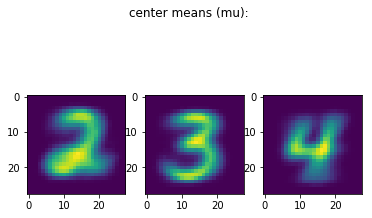

In [209]:
# Set seed to random again
# random.seed()

K = 3
mu_true = np.zeros((K, 784))
mu_true[0, :] = np.mean(samples[sample_labels == 2], axis=0)
mu_true[1, :] = np.mean(samples[sample_labels == 3], axis=0)
mu_true[2, :] = np.mean(samples[sample_labels == 4], axis=0)
pi_true = np.ones(K)*(samples_per_class/samples.shape[0])

reconstruction_visualization(mu_true, pi_true, samples_per_class, samples)
print("True means:")

In [210]:
mu, gamma, best_log_likelihood, pi = EM(samples, 3, 200, mu_true, pi_true)

itaration:  0 / 200
itaration:  20 / 200
itaration:  40 / 200
itaration:  60 / 200
itaration:  80 / 200
itaration:  100 / 200
itaration:  120 / 200
itaration:  140 / 200
itaration:  160 / 200
itaration:  180 / 200


Mixing coefficients:  [ 0.307  0.337  0.356]
True mixing coefficients:  [ 0.333  0.333  0.333]


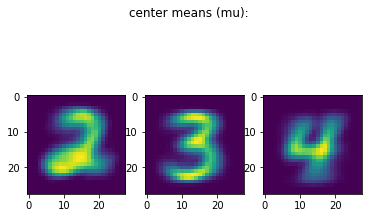

In [212]:
reconstruction_visualization(mu, pi, samples_per_class, samples)

One might expect that initalizing EM with the true parameters would lead to immediate convergence. The experiment, however, shows that this is not the case. The algorithm adjusts the paramters away from the true values. This can be explained by the fact that the EM-algorithm uses a log bernoulli objective (ie. minimize the pixel-to-pixel difference of the mean and a datapoint). Therefore any variance in the handwriting can cause a digit to be interpreted as for example a 2 instead of a 3. So the likelihood can be increased by increasing the responsibility of the cluster of 2's for that datapoint, shifting away from the true parameters.

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [213]:
import torch.nn.functional as F

def log_bernoulli_loss(x_hat, x):
    
    stabilizer = 0
    loss = x * torch.log(x_hat + stabilizer) + (1 - x) * torch.log(1 - x_hat + stabilizer)
    loss = -torch.sum(loss)
#     loss = F.binary_cross_entropy(x_hat, x, size_average=False)    
    return loss


In [214]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!

% TODO: Derivation

$$ -KL(q||p) = \frac{1}{2} * \sum_{j=1}^J (1 + log(\sigma_j^2) - \mu_j^2 - \sigma_j^2) $$

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [215]:
def KL_loss(mu, logvar):
    
    loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())   
    return loss


In [216]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [217]:
def loss_function(x_hat, x, mu, logvar):
    
    recon = log_bernoulli_loss(x_hat, x)
    kl = KL_loss(mu, logvar)
    
    loss = recon + kl
    
    return loss


In [218]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [219]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [220]:
def encode(self, x):
    
    embed = self.fc1(x)
    embed = F.sigmoid(embed)
    
    mu = self.fc21(embed)
    logvar = self.fc22(embed)
        
    return mu, logvar

In [221]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [222]:
def reparameterize(self, mu, logvar):
        
        eps = torch.randn_like(mu)
        z = mu + torch.sqrt(torch.exp(logvar)) * eps

        return z


In [223]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [224]:
def decode(self, z):
    
    x_hat = self.fc3(z)
    x_hat = F.relu(x_hat)
    x_hat = self.fc4(x_hat)
    x_hat = F.sigmoid(x_hat)
    
    return x_hat


In [225]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [226]:
def forward(self, x):
    x = x.view(-1, 784)
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decode(z)
    return x_hat, mu, logvar


In [227]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [228]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [229]:
# Hyperparameters
latent_dim = 2
hidden_dim = 256
fc1_dims = (784,hidden_dim)
fc21_dims = (hidden_dim, latent_dim)
fc22_dims = (hidden_dim, latent_dim)
fc3_dims = (latent_dim, hidden_dim)
fc4_dims = (hidden_dim, 784)
lr = 1e-3
batch_size = 128
epochs = 5



In [230]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [231]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 551.436462
Train Epoch: 1 [12800/60000 (21%)]	Loss: 197.774521
Train Epoch: 1 [25600/60000 (43%)]	Loss: 179.095322
Train Epoch: 1 [38400/60000 (64%)]	Loss: 178.015198
Train Epoch: 1 [51200/60000 (85%)]	Loss: 180.795761
====> Epoch: 1 Average loss: 197.4037
Train Epoch: 2 [0/60000 (0%)]	Loss: 173.664200
Train Epoch: 2 [12800/60000 (21%)]	Loss: 169.992172
Train Epoch: 2 [25600/60000 (43%)]	Loss: 172.447906
Train Epoch: 2 [38400/60000 (64%)]	Loss: 168.788177
Train Epoch: 2 [51200/60000 (85%)]	Loss: 162.426743
====> Epoch: 2 Average loss: 170.8643
Train Epoch: 3 [0/60000 (0%)]	Loss: 160.821365
Train Epoch: 3 [12800/60000 (21%)]	Loss: 170.384735
Train Epoch: 3 [25600/60000 (43%)]	Loss: 167.702362
Train Epoch: 3 [38400/60000 (64%)]	Loss: 155.952057
Train Epoch: 3 [51200/60000 (85%)]	Loss: 178.356018
====> Epoch: 3 Average loss: 165.1932
Train Epoch: 4 [0/60000 (0%)]	Loss: 166.034409
Train Epoch: 4 [12800/60000 (21%)]	Loss: 159.372238
Train Epoch: 4 [25600/

Run the box below to check if the model you trained above is able to correctly reconstruct images.

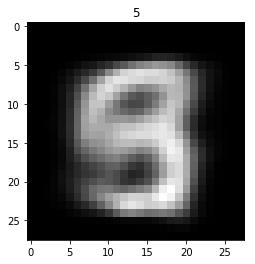

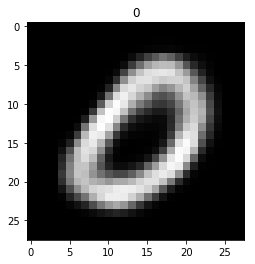

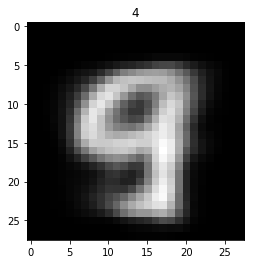

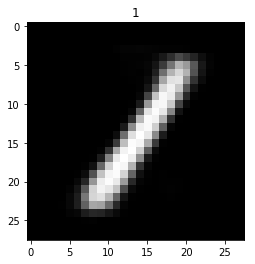

In [232]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

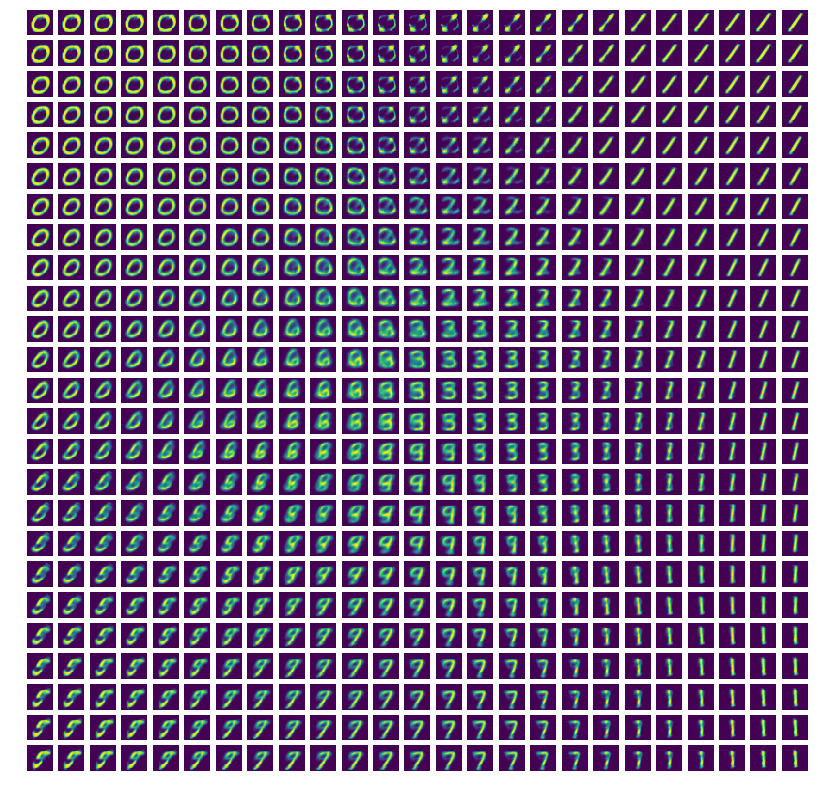

In [233]:
N = 25
rows = np.linspace(-3, 3, N)
cols = rows.copy()

fig, ax = plt.subplots(N, N, figsize=(14,14))

for i_idx, i in enumerate(rows):
    for j_idx, j in enumerate(cols):
        
        # Build tensor t
        z = torch.FloatTensor([i, j]).unsqueeze(0)
        x = VAE_MNIST.decode(z).data.numpy()
        ax[i_idx,j_idx].imshow(x.reshape(28, -1))
        ax[i_idx,j_idx].axis('off')

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


TODO: http://ruishu.io/2017/11/07/amortized-optimization/

Amortized inference is a term used to describe the process of doing inference on multiple related problems concurrently. A Variational Auto-encoder uses amortized inference to solve the sub-problems of optimizing the posterior distribution $p(z|x)$ by learning a function $f$ (the encoder) that maps from x to z. The benefit of this is that it by-passes the need to optimize the posterior for every data point seperately. And in addition to that, the learned function can be used to predict the latent variables that generated a new observation.
This is found in the code at the part where the encoder is coded.

